In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import math
import os
import shutil
from sklearn.model_selection import train_test_split
import os


In [2]:
class SelfAttention(nn.Module):
  def __init__(self, n_heads, embd_dim, in_proj_bias=True, out_proj_bias=True):
    super().__init__()
    self.n_heads = n_heads
    self.in_proj = nn.Linear(embd_dim, 3 * embd_dim, bias=in_proj_bias)
    self.out_proj = nn.Linear(embd_dim, embd_dim, bias=out_proj_bias)

    self.d_heads = embd_dim // n_heads

  def forward(self, x, casual_mask=False):
    # x: (batch_size, seq_len, dim)

    batch_size, seq_len, d_emed = x.shape

    interim_shape = (batch_size, seq_len, self.n_heads, self.d_heads)

    # (batch_size, seq_len, dim) -> 3 * (batch_size, seq_len, d_embed)
    q, k, v = self.in_proj(x).chunk(3, dim=-1)

    # change the shape of q, k and v to match the interim shape
    q = q.view(interim_shape)
    k = k.view(interim_shape)
    v = v.view(interim_shape)

    # swap the elements within matrix using transpose
    # take n_heads before seq_len, like that: (batch_size, n_heads, seq_len, d_embed)
    q = q.transpose(1, 2)
    k = k.transpose(1, 2)
    v = v.transpose(1, 2)

    # calculate the attention
    weight = q @ k.transpose(-1, -2)

    if casual_mask:
        # mask where the upper traingle (above the prinicpal dagonal) is 1
        mask = torch.ones_like(weight, dtype=torch.bool).triu(1)
        # fill the upper traingle with -inf
        weight.masked_fill_(mask, -torch.inf)

    weight /= math.sqrt(self.d_heads)

    weight = F.softmax(weight, dim=-1)

    # (batch_size, h_heads, seq_len, dim / h)
    output = weight @ v

    # (batch_size, h_heads, seq_len, dim / h) -> (batch_size, seq_len, n_heads, dim / h)
    output = output.transpose(1, 2)

    # change the shape to the shape of out_proj
    output = output.reshape((batch_size, seq_len, d_emed))

    output = self.out_proj(output)

    return output






In [3]:

class AttentionBlock(nn.Module):
  def __init__(self, channels):
      super().__init__()
      self.groupnorm = nn.GroupNorm(32, channels)
      self.attention = SelfAttention(1, channels)

  def forward(self, x):
      # x: (batch_size, channels, h, w)
      residual = x.clone()

      # (batch_size, channels, h, w) -> (batch_size, channels, h, w)
      x = self.groupnorm(x)

      n, c, h, w = x.shape

      # (batch_size, channels, h, w) -> (batch_size, channels, h * w)
      x = x.view((n, c, h * w))

      # (batch_size, channels, h * w) -> (batch_size, h * w, channels)
      x = x.transpose(-1, -2)

      # perform self-attention without mask
      # (batch_size, h * w, channels) -> (batch_size, h * w, channels)
      x = self.attention(x)

      # (batch_size, h * w, channels) -> (batch_size, channels, h * w)
      x = x.transpose(-1, -2)

      # (batch_size, channels, h * w) -> (batch_size, channels, h, w)
      x = x.view((n, c, h, w))

      # (batch_size, channels, h, w) -> (batch_size, channels, h, w)
      x += residual

      return x



In [4]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.groupnorm1 = nn.GroupNorm(32, in_channels)
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    self.groupnorm2 = nn.GroupNorm(32, out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    if in_channels == out_channels:
      self.residual_layer = nn.Identity()
    else:
      self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

  def forward(self, x):
    # x: (batch_size, in_channels, h, w)
    residue = x.clone()

    x = self.groupnorm1(x)
    x = F.selu(x)
    x = self.conv1(x)
    x = self.groupnorm2(x)
    x = self.conv2(x)

    return x + self.residual_layer(residue)

In [5]:

class Encoder(nn.Sequential):
    def  __init__(self):
        super().__init__(
            # (batch_size, channel, h, w) -> (batch_size, 128, h, w)
            nn.Conv2d(3, 128, kernel_size=3, padding=1),

            # (batch_size, 128, h, w) -> (batch_size, 128, h, w)
            ResidualBlock(128, 128),

            # (batch_size, 128, h, w) -> (batch_size, 128, h / 2, w / 2)
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),

            # (batch_size, 128, h / 2, w / 2) -> (batch_size, 256, h / 2, w / 2)
            ResidualBlock(128, 256),

            # (batch_size, 256, h / 2, w / 2) -> (batch_size, 256, h / 2, w / 2)
            ResidualBlock(256, 256),

            # (batch_size, 256, h / 2, w / 2) -> (batch_size, 256, h / 4, w / 4)
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0),

            # (batch_size, 256, h / 4, w / 4) -> (batch_size, 512, h / 4, w / 4)
            ResidualBlock(256, 512),

            # (batch_size, 512, h / 4, w / 4) -> (batch_size, 512, h / 4, w / 4)
            ResidualBlock(512, 512),

            # (batch_size, 512, h / 4, w / 4) -> (batch_size, 512, h / 8, w / 8)
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=0),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            ResidualBlock(512, 512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            ResidualBlock(512, 512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            ResidualBlock(512, 512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            AttentionBlock(512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            ResidualBlock(512, 512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            nn.GroupNorm(32, 512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            nn.SiLU(),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 8, h / 8, w / 8)
            nn.Conv2d(512, 8, kernel_size=3, padding=1),

            # (batch_size, 8, h / 8, w / 8) -> (batch_size, 8, h / 8, w / 8)
            nn.Conv2d(8, 8, kernel_size=1, padding=0)
        )
    def forward(self, x):
        # x: (batch_size, channel, h, w)

        for module in self:
            if isinstance(module, nn.Conv2d) and module.stride == (2, 2):
                x = F.pad(x, (0, 1, 0, 1))  # (left, right, top, bottom)
            x = module(x)

        # (batch_size, 8, h / 8, w / 8) -> two tensors of shape (batch_size, 4, h / 8, w / 8)
        mean, log_variance = torch.chunk(x, 2, dim=1)

        # Clamp log variance between -30 and 20
        log_variance = torch.clamp(log_variance, -30, 20)

        # Reparameterization trick
        std = torch.exp(0.5 * log_variance)
        eps = torch.randn_like(std)
        x = mean + eps * std

        # Scale the latent representation
        x *= 0.18215

        return x


In [6]:

class Decoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            # (batch_size, 4, 32, 32) -> (batch_size, 512, 32, 32)
            nn.Conv2d(4, 512, kernel_size=3, padding=1),

            # (batch_size, 512, 32, 32) -> (batch_size, 512, 32, 32)
            ResidualBlock(512, 512),

            # (batch_Size, 512, 32, 32) -> (batch_size, 512, 32, 32)
            AttentionBlock(512),

            # (batch_size, 512, 32, 32) -> (batch_size, 512, 32, 32)
            ResidualBlock(512, 512),

            # (batch_size, 512, 32, 32) -> (batch_size, 512, 32, 32)
            ResidualBlock(512, 512),

            # (batch_size, 512, 32, 32) -> (batch_size, 512, 32, 32)
            ResidualBlock(512, 512),

            # (batch_size, 512, 32, 32) -> (batch_size, 512, 64, 64)
            nn.Upsample(scale_factor=2),

            # (batch_size, 512, 64, 64) -> (batch_size, 512, 64, 64)
            nn.Conv2d(512, 512, kernel_size=3, padding=1),

            # (batch_size, 512, 64, 64) -> (batch_size, 512, 64, 64)
            ResidualBlock(512, 512),

            # (batch_size, 512, 64, 64) -> (batch_size, 512, 64, 64)
            ResidualBlock(512, 512),

            # (batch_size, 512, 64, 64) -> (batch_size, 512, 64, 64)
            ResidualBlock(512, 512),

            # (batch_size, 512, 64, 64) -> (batch_size, 512, 128, 128)
            nn.Upsample(scale_factor=2),

            # (batch_size, 512, 128, 128) -> (batch_size, 512, 128, 128)
            nn.Conv2d(512, 512, kernel_size=3, padding=1),

            # (batch_size, 512, 128, 128) -> (batch_size, 256, 128, 128)
            ResidualBlock(512, 256),

            # (batch_size, 256, 128, 128) -> (batch_size, 256, 128, 128)
            ResidualBlock(256, 256),

            # (batch_size, 256, 128, 128) -> (batch_size, 256, 128, 128)
            ResidualBlock(256, 256),

            # (batch_size, 256, 128, 128) -> (batch_size, 256, 256, 256)
            nn.Upsample(scale_factor=2),

            # (batch_size, 256, 256, 256) -> (batch_size, 256, 256, 256)
            nn.Conv2d(256, 256, kernel_size=3, padding=1),

            # (batch_size, 256, 256, 256) -> (batch_size, 128, 256, 256)
            ResidualBlock(256, 128),

            # (batch_size, 128, 256, 256) -> (batch_size, 128, 256, 256)
            ResidualBlock(128, 128),

            # (batch_size, 128, 256, 256) -> (batch_size, 128, 256, 256)
            ResidualBlock(128, 128),

            nn.GroupNorm(32, 128),

            nn.SiLU(),

            # (batch_size, 128, 256, 256) -> (batch_size, 3, 256, 256)
            nn.Conv2d(128, 3, kernel_size=3, padding=1),
        )
    def forward(self, x):
        # x: (batch_size, 4, h / 8, w / 8)

        # remove the scaling adding by the encoder
        x /= 0.18215

        for module in self:
            x = module(x)

        # (batch_size, 3, h, w)
        return x

In [7]:
!gdown 1KXRTB_q4uub_XOHecpsQjE4Kmv76sZbV

Downloading...
From (original): https://drive.google.com/uc?id=1KXRTB_q4uub_XOHecpsQjE4Kmv76sZbV
From (redirected): https://drive.google.com/uc?id=1KXRTB_q4uub_XOHecpsQjE4Kmv76sZbV&confirm=t&uuid=84f423fb-5a1e-495b-9817-625455e011d1
To: /content/all-dogs.zip
100% 775M/775M [00:22<00:00, 34.5MB/s]


In [8]:
!unzip all-dogs.zip

Streaming output truncated to the last 5000 lines.
  inflating: all-dogs/n02113624_8890.jpg  
  inflating: all-dogs/n02107683_215.jpg  
  inflating: all-dogs/n02093428_5326.jpg  
  inflating: all-dogs/n02105412_8018.jpg  
  inflating: all-dogs/n02093647_3129.jpg  
  inflating: all-dogs/n02088466_8078.jpg  
  inflating: all-dogs/n02108915_4214.jpg  
  inflating: all-dogs/n02089078_2841.jpg  
  inflating: all-dogs/n02105855_3498.jpg  
  inflating: all-dogs/n02094114_2823.jpg  
  inflating: all-dogs/n02088094_649.jpg  
  inflating: all-dogs/n02091831_2232.jpg  
  inflating: all-dogs/n02096585_3105.jpg  
  inflating: all-dogs/n02109961_977.jpg  
  inflating: all-dogs/n02097047_5869.jpg  
  inflating: all-dogs/n02106030_16250.jpg  
  inflating: all-dogs/n02110958_13721.jpg  
  inflating: all-dogs/n02107142_8437.jpg  
  inflating: all-dogs/n02094433_1312.jpg  
  inflating: all-dogs/n02097474_5481.jpg  
  inflating: all-dogs/n02097130_1531.jpg  
  inflating: all-dogs/n02092339_284.jpg  
  inf

In [9]:
def split_dataset(source_dir, train_dir, test_dir, test_size=0.2, random_state=42):
    image_files = [f for f in os.listdir(source_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    train_files, test_files = train_test_split(image_files, test_size=test_size, random_state=random_state)

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for file in train_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(train_dir, file))

    for file in test_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(test_dir, file))

    print(f"Dataset split complete. {len(train_files)} training images, {len(test_files)} test images.")

source_dir = "./all-dogs"
train_dir = "./data/train/dogs"
test_dir = "./data/test/dogs"

split_dataset(source_dir, train_dir, test_dir)

Dataset split complete. 16463 training images, 4116 test images.


# Implement VAE

In [10]:
# Model
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# Train The VAE

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
# from model import Encoder, Decoder

# Device configuration
device = torch.device('cuda')

# Hyperparameters
num_epochs = 10
learning_rate = 1e-4
beta = 0.00025  # KL divergence weight

# Data loading
transform = transforms.Compose([
    transforms.Resize((56, 56)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 4
dataset = torchvision.datasets.ImageFolder(root='./data/train', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Add these hyperparameters
accumulation_steps = 1  # Adjust as needed
effective_batch_size = batch_size * accumulation_steps

train_losses = []

# training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (images, _) in enumerate(dataloader):
        images = images.to(device)

        # Forward pass
        reconstructed, encoded = model(images)

        # Compute loss
        recon_loss = nn.MSELoss()(reconstructed, images)

        # Extract mean and log_variance from encoded
        mean, log_variance = torch.chunk(encoded, 2, dim=1)

        kl_div = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())
        loss = recon_loss + beta * kl_div

        # Normalize the loss to account for accumulation
        loss = loss / accumulation_steps

        # Backward pass
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        train_loss += loss.item() * accumulation_steps

        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], '
              f'Loss: {loss.item()*accumulation_steps:.4f}, Recon Loss: {recon_loss.item():.4f}, KL Div: {kl_div.item():.4f}')



        with torch.no_grad():
            # Take the first image from the batch
            sample_image = images[0].unsqueeze(0)
            sample_reconstructed = model(sample_image)[0]

            sample_image = (sample_image * 0.5) + 0.5
            sample_reconstructed = (sample_reconstructed * 0.5) + 0.5

            torchvision.utils.save_image(sample_reconstructed, 'reconstructed.png')

    train_losses.append(train_loss / len(dataloader))
  # Save the model checkpoint
    torch.save(model.state_dict(), f'vae_model_epoch_{epoch+1}.pth')

print('Training finished!')

Streaming output truncated to the last 5000 lines.
Epoch [9/10], Step [3234/4116], Loss: 0.0176, Recon Loss: 0.0172, KL Div: 1.2772
Epoch [9/10], Step [3235/4116], Loss: 0.0181, Recon Loss: 0.0178, KL Div: 1.2804
Epoch [9/10], Step [3236/4116], Loss: 0.0275, Recon Loss: 0.0273, KL Div: 1.0827
Epoch [9/10], Step [3237/4116], Loss: 0.0193, Recon Loss: 0.0190, KL Div: 1.1581
Epoch [9/10], Step [3238/4116], Loss: 0.0227, Recon Loss: 0.0224, KL Div: 1.3821
Epoch [9/10], Step [3239/4116], Loss: 0.0289, Recon Loss: 0.0286, KL Div: 1.1536
Epoch [9/10], Step [3240/4116], Loss: 0.0299, Recon Loss: 0.0295, KL Div: 1.7641
Epoch [9/10], Step [3241/4116], Loss: 0.0193, Recon Loss: 0.0190, KL Div: 1.3493
Epoch [9/10], Step [3242/4116], Loss: 0.0201, Recon Loss: 0.0198, KL Div: 0.9772
Epoch [9/10], Step [3243/4116], Loss: 0.0215, Recon Loss: 0.0212, KL Div: 0.9688
Epoch [9/10], Step [3244/4116], Loss: 0.0143, Recon Loss: 0.0141, KL Div: 0.7694
Epoch [9/10], Step [3245/4116], Loss: 0.0217, Recon Loss: 

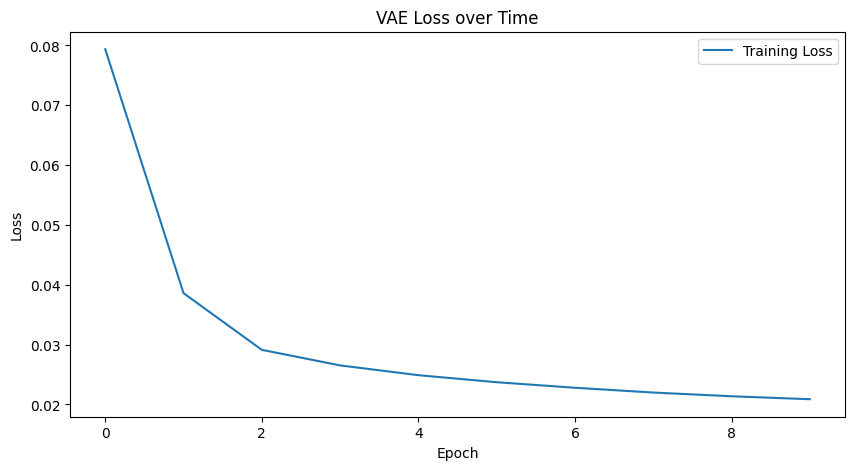

In [12]:
import matplotlib.pyplot as plt

# plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Loss over Time')
plt.legend()
plt.show()

# Custom VAE

In [13]:
class CustomVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        x_reconstructed = self.decode(z)
        return x_reconstructed

    def load_pretrained_weights(self, weight_path):
      self.load_state_dict(torch.load(weight_path))

In [14]:
from diffusers import AutoencoderKL

class DiffuserCompatibleVAE(AutoencoderKL):
    def __init__(self, vae):
        super().__init__()
        self.vae  = vae

    def encode(self, x):
        mean, log_var = self.vae.encoder(x)
        return mean, log_var

    def decode(self, z, **kwargs):
        print("Input shape:", z.shape)
        out = self.vae.decoder(z).unsqueeze(0)
        print(out.shape)
        return out

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [15]:
from huggingface_hub import snapshot_download

snapshot_download('CompVis/stable-diffusion-v1-4', local_dir='./model')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Fetching 33 files:   0%|          | 0/33 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/17.1k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

pytorch_model.fp16.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

pytorch_model.fp16.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.non_ema.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

(…)fusion_pytorch_model.non_ema.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

v1-variants-scores.jpg:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

'/content/model'

In [16]:
AutoencoderKL.from_pretrained('./model/vae')

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [19]:
import torch

weights = torch.load("/content/vae_model_epoch_10.pth", map_location="cpu")

new_weights = {}
for k, v in weights.items():
    new_key = k.replace("_", "")

    new_key = new_key.replace("residuallayer", "residual_layer") \
                     .replace("inproj", "in_proj") \
                     .replace("outproj", "out_proj")

    new_weights[new_key] = v

vae = CustomVAE()
vae.load_state_dict(new_weights)

device = torch.device("cuda" if torch.cuda.is_available() else "mpa" if torch.backends.mps.is_available() else "cpu")
vae = vae.to(device)

<ipython-input-19-47ffbc0870a6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load("/content/vae_model_epoch_10.pth", map_location="cpu")


In [20]:
vae

CustomVAE(
  (encoder): Encoder(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ResidualBlock(
      (groupnorm1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (groupnorm2): GroupNorm(32, 128, eps=1e-05, affine=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (residual_layer): Identity()
    )
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
    (3): ResidualBlock(
      (groupnorm1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (groupnorm2): GroupNorm(32, 256, eps=1e-05, affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (residual_layer): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (4): ResidualBlock(
      (groupnorm1): GroupNorm(32, 256, eps=1e-05, af

In [22]:
from diffusers import StableDiffusionPipeline
import torch

vae = CustomVAE()
compatible_vae = DiffuserCompatibleVAE(vae=vae)
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", vae=compatible_vae)
pipe = pipe.to("cuda")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [24]:
# generate an image
prompt = "a photo of a dog"
image = pipe(prompt, num_inference_steps=50).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

Input shape: torch.Size([1, 4, 64, 64])
torch.Size([1, 1, 3, 512, 512])


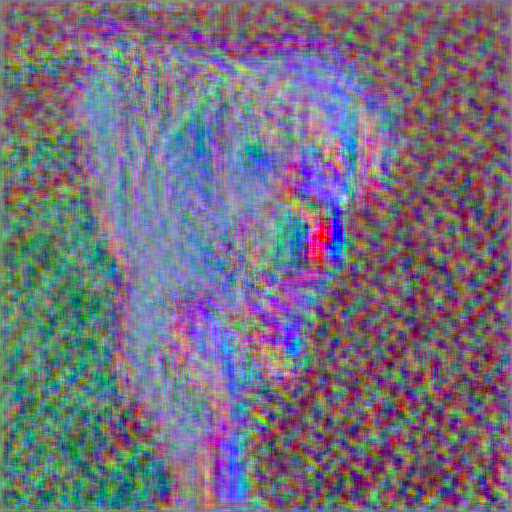

In [25]:
image